In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, auc, roc_curve
import itertools
import yaml
import os
import numpy as np
from sklearn.metrics import auc
from statistics import mean
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
pd.set_option('display.max_columns', None)


In [2]:
def calculate_auc_avg(tickers, predictions, true_values):
    predictions = predictions.sort_values(by='fecha')
    true_values = true_values.sort_values(by='fecha')
    
    
    # renombro las columnas
    column_names = {}
    for column in predictions.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_pred'
    
    predictions = predictions.rename(columns=column_names)
    
    column_names = {}
    for column in true_values.columns:
        if column != 'fecha':
            column_names[column] = f'{column}_true'
    
    true_values = true_values.rename(columns=column_names)
    performance = pd.concat(
        [
            predictions,
            true_values
        ], axis=1, join="inner"
    )
    
    auc_list = []
    for ticker in tickers:
        y_true = performance[performance[f'{ticker}_true'].notna()][f'{ticker}_true']
        y_pred = performance[performance[f'{ticker}_pred'].notna()][f'{ticker}_pred']
        
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        
        auc_list.append(precision)

    return mean(auc_list)

In [3]:
def max_drawdown(serie):
    max_valor_acumulado = serie[0]
    max_dd = 0

    for valor_actual in serie[1:]:
        if valor_actual > max_valor_acumulado:
            max_valor_acumulado = valor_actual
        else:
            dd = (max_valor_acumulado - valor_actual) / max_valor_acumulado
            if dd > max_dd:
                max_dd = dd

    return max_dd

In [4]:
def calculate_avg_returns_perc(orders):
    orders_per_month = orders[['close_time','profit', 'comment']].copy()
    orders_per_month['close_time'] = pd.to_datetime(orders_per_month['close_time'])
    orders_per_month['year'] = orders_per_month['close_time'].dt.year
    orders_per_month['month'] = orders_per_month['close_time'].dt.month
    
    orders_per_month_gb = orders_per_month.groupby(by=['year','month']).agg(
        profit_sum=('profit', 'sum'),
    ).reset_index()
    
    orders_per_month_gb = pd.concat([
        pd.DataFrame({'year':[2023], 'month':[0],'amount_ops':[0], 'profit_sum':[initial_wallet_value]}), 
        orders_per_month_gb
    ])
    
    orders_per_month_gb['profit_cumsum'] = orders_per_month_gb['profit_sum'].cumsum()
    
    orders_per_month_gb['perc_change'] = ((orders_per_month_gb['profit_cumsum'] - orders_per_month_gb['profit_cumsum'].shift(1)) / orders_per_month_gb['profit_cumsum'].shift(1))
    
    return orders_per_month_gb.perc_change.mean(), orders_per_month_gb.perc_change.std()

In [5]:
with open('configs/parameters.yml', 'r') as archivo:
    parameters = yaml.safe_load(archivo)

In [6]:
eta = 0
for param, value in parameters.items():
    if eta == 0:
        eta += len(value)
    else:
        eta *= len(value)

eta = (eta * 10) / 60

print(f'el tiempo estimado de los experimentos es de {round(eta, 2)} horas')

el tiempo estimado de los experimentos es de 53.33 horas


In [7]:
with open('configs/project_config.yml', 'r') as archivo:
    config = yaml.safe_load(archivo)

In [8]:
tickers = config["tickers"] 
tickers

['EURUSD', 'GBPUSD', 'USDJPY', 'USDCAD', 'AUDUSD', 'USDCHF']

In [9]:
os.listdir('./backbone/data/backtest/experiments')

['Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_10-RR_2-CloseByTimeTrue-TS_True',
 'Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_10-RR_3-CloseByTimeTrue-TS_True',
 'Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_10-RR_5-CloseByTimeTrue-TS_False',
 'Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_10-RR_7-CloseByTimeTrue-TS_False',
 'Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_15-RR_2-CloseByTimeTrue-TS_False',
 'Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_15-RR_3-CloseByTimeTrue-TS_True',
 'Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_15-RR_5-CloseByTimeTrue-TS_False',
 'Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strat

In [10]:
results_dict = {}
initial_wallet_value = config['start_money']

for path in os.listdir('./backbone/data/backtest/experiments'):
    if not path.endswith('.csv') and path.startswith('Mode_train'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'wallet.csv'))

            final_wallet_value = wallet.tail(1).iloc[0]['wallet']
            results_dict[path]['wallet'] = ((final_wallet_value - initial_wallet_value) / initial_wallet_value) * 100
            results_dict[path]['max_drawdown'] = max_drawdown(wallet['wallet'])
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'orders.csv'))

            mean_returns, std_returns = calculate_avg_returns_perc(orders)
            results_dict[path]['mean_perc_returns'] = mean_returns
            results_dict[path]['std_perc_returns'] = std_returns
            
            
            results_dict[path]['buys'] = orders[orders['open_time'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_time'].notna()].shape[0]
           
            # avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            # results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] >= 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] < 0].shape[0]
    
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 


            # Tasa de rendimiento libre de riesgo anual
            annual_risk_free_rate = 0.02
            hours_per_year = 252 * 24
            hourly_risk_free_rate = (1 + annual_risk_free_rate) ** (1/hours_per_year) - 1
            mean_hourly_return = orders['profit'].mean()
            std_hourly_return = orders['profit'].std()
            sharpe_ratio_hourly = (mean_hourly_return - hourly_risk_free_rate) / std_hourly_return
            sharpe_ratio_annualized = sharpe_ratio_hourly * np.sqrt(hours_per_year)

            results_dict[path]['sharpe_ratio'] = sharpe_ratio_annualized
        
            results_dict[path]['winning_rate'] = orders[orders['profit'] >= 0]['profit'].mean() / (-1 * orders[orders['profit'] < 0]['profit'].mean())
            
            results_dict[path]['recover_factor'] = orders[orders['profit'] >= 0]['profit'].sum() / (-1 * orders[orders['profit'] < 0]['profit'].sum())

            results_dict[path]['stability_index'] = orders['profit'].std() / orders['profit'].mean()

            for ticker in tickers:
                results_dict[path][f'profits_in_{ticker}'] = orders[orders['ticker'] == ticker]['profit'].sum()

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0
        # try:
        train_results = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'trainres.csv')).dropna()
        results_dict[path]['avg_train_precision'] = train_results['precision'].mean()
        results_dict[path]['avg_train_recall'] = train_results['recall'].mean()
        results_dict[path]['avg_train_f1'] = train_results['f1'].mean()
        # # except:
        # #     results_dict[path]['avg_train_auc'] = 0
            
        # # try:
        predictions = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'test_res.csv')).dropna()

        results_dict[path]['avg_test_precision'] = precision_score(predictions.y_true, predictions.y_pred, average='weighted')
        results_dict[path]['avg_test_recall'] = recall_score(predictions.y_true, predictions.y_pred, average='weighted')
        results_dict[path]['avg_test_f1'] = f1_score(predictions.y_true, predictions.y_pred, average='weighted')
        # except:
        #     results_dict[path]['avg_test_auc'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')

Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_10-RR_2-CloseByTimeTrue-TS_True
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_10-RR_3-CloseByTimeTrue-TS_True
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_10-RR_5-CloseByTimeTrue-TS_False
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_10-RR_7-CloseByTimeTrue-TS_False
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_15-RR_2-CloseByTimeTrue-TS_False
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_15-RR_3-CloseByTimeTrue-TS_True
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_15-RR_5-CloseByTimeTrue-TS_False
Mode_train-Model_gradient_boosting-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_15-RR_5-Clos

In [11]:
beta = 0.05
eurusd = pd.read_csv('./backbone/data/backtest/symbols/EURUSD.csv')
results['buy_ratio'] = results['buys'] / (eurusd.Date.nunique() * len(tickers))
results['operation_ratio_2'] = ((1 + beta**2) * results['operation_ratio'] * results['buy_ratio']) / (beta * results['operation_ratio'] + results['buy_ratio'])

In [12]:
positive_results = results[
    [
        'operation_ratio_2',
        'operation_ratio', 
        'buy_ratio',
        'mean_perc_returns',
        'std_perc_returns',
        'winning_rate',
        'recover_factor',
        'sharpe_ratio',
        'stability_index',
        'max_drawdown',
        'good_operations',
        'bad_operations',
        'wallet',
        # 'profits_in_EURUSD',
        # 'profits_in_GBPUSD', 
        # # 'profits_in_USDJPY', 
        # 'profits_in_USDCAD',
        # 'profits_in_AUDUSD', 
        # 'profits_in_USDCHF',
        'avg_train_precision',
        'avg_train_recall',
        'avg_train_f1',
        'avg_test_precision',
        'avg_test_recall',
        'avg_test_f1',
    ]
]#.sort_values(by='sharpe_ratio', ascending=False)

positive_results = positive_results[
    (results['wallet']>5000)
    & (results['max_drawdown']<=0.1)
].sort_values(by='sharpe_ratio', ascending=False)


positive_results

,operation_ratio_2,operation_ratio,buy_ratio,mean_perc_returns,std_perc_returns,winning_rate,recover_factor,sharpe_ratio,stability_index,max_drawdown,good_operations,bad_operations,wallet,avg_train_precision,avg_train_recall,avg_train_f1,avg_test_precision,avg_test_recall,avg_test_f1
Mode_train-Model_random_forest-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_2-CloseByTimeTrue-TS_False,0.100708,0.636542,0.005964,0.394925,0.109571,1.673034,2.930070,26.872348,2.894012,0.095894,324,185,5150.796816,0.784805,0.758855,0.763523,0.785799,0.452513,0.534981
Mode_train-Model_random_forest-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_15-RR_2-CloseByTimeTrue-TS_False,0.103013,0.606061,0.006187,0.400175,0.122568,1.770459,2.723784,24.290855,3.201571,0.087046,320,208,5339.781986,0.845161,0.830385,0.833104,0.787991,0.453622,0.535769
Mode_train-Model_random_forest-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_3-CloseByTimeTrue-TS_False,0.095181,0.595436,0.005648,0.436754,0.143178,2.086118,3.070338,24.239304,3.208380,0.078480,287,195,7236.891788,0.833439,0.827593,0.827934,0.806799,0.483370,0.573335
Mode_train-Model_gradient_boosting-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_8-SL_15-RR_3-CloseByTimeTrue-TS_True,0.100742,0.573077,0.006093,0.406635,0.162045,2.295444,3.081272,24.116100,3.224770,0.078452,298,222,5496.973395,0.831725,0.829233,0.829473,0.814306,0.468034,0.557260
Mode_train-Model_random_forest-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_24-SL_15-RR_2-CloseByTimeTrue-TS_False,0.103598,0.598499,0.006245,0.418269,0.167560,1.754604,2.615507,24.046108,3.234157,0.095990,319,214,6058.895400,0.850389,0.837194,0.839310,0.799678,0.467664,0.548738
Mode_train-Model_random_forest-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_15-RR_2-CloseByTimeTrue-TS_False,0.109139,0.612389,0.006620,0.443519,0.118214,1.708322,2.698992,24.037225,3.235352,0.096164,346,219,7783.179350,0.699186,0.696071,0.697012,0.796883,0.445307,0.525580
Mode_train-Model_random_forest-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_48-SL_15-RR_2-CloseByTimeTrue-TS_False,0.106204,0.585145,0.006468,0.405958,0.114872,1.778678,2.508791,23.559842,3.300909,0.086859,323,229,5655.476550,0.849339,0.839831,0.841736,0.794415,0.439948,0.520618
Mode_train-Model_random_forest-TrainWw_11520-TrainPd_24-TradStgy_ml_strategy-PerFwTg_48-SL_15-RR_5-CloseByTimeTrue-TS_False,0.068318,0.420749,0.004066,0.535057,0.241924,5.050863,3.668786,23.472760,3.313155,0.086670,146,201,14770.742400,0.681806,0.681438,0.678825,0.841608,0.579638,0.667621
Mode_train-Model_gradient_boosting-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_12-SL_15-RR_2-CloseByTimeTrue-TS_False,0.111993,0.594549,0.006878,0.438920,0.122702,1.725565,2.530346,22.390858,3.473243,0.086672,349,238,7472.422862,0.848646,0.842902,0.844356,0.800130,0.434035,0.512907
Mode_train-Model_gradient_boosting-TrainWw_5760-TrainPd_24-TradStgy_ml_strategy-PerFwTg_48-SL_15-RR_3-CloseByTimeTrue-TS_True,0.104677,0.563071,0.006409,0.403677,0.122741,2.119967,2.732007,21.985548,3.537273,0.095762,308,239,5510.757473,0.893077,0.892447,0.892429,0.841456,0.549520,0.631260


In [13]:
# Mode_train-Model_gradient_boosting-TrainWw_960-TrainPd_24-TradingStgy_ml_strategy-PeriodsFwTg_6-SL_10-RR_7-UseDaysClose_True
# Mode_train-Model_gradient_boosting-TrainWw_1920-TrainPd_24-TradingStgy_ml_strategy-PeriodsFwTg_6-SL_10-RR_7-UseDaysClose_True
# Mode_train-Model_random_forest-TrainWw_1920-TrainPd_24-TradingStgy_ml_strategy-PeriodsFwTg_6-SL_10-RR_7-UseDaysClose_True
# Mode_train-Model_gradient_boosting-TrainWw_1440-TrainPd_24-TradingStgy_ml_strategy-PeriodsFwTg_24-SL_10-RR_5-UseDaysClose_True

In [14]:
# columns = [
#     'profits_in_EURUSD',
#     'profits_in_GBPUSD', 
#     'profits_in_USDJPY', 
#     'profits_in_USDCAD',
#     'profits_in_AUDUSD', 
#     'profits_in_USDCHF'
# ]

# positive_results[columns].describe()

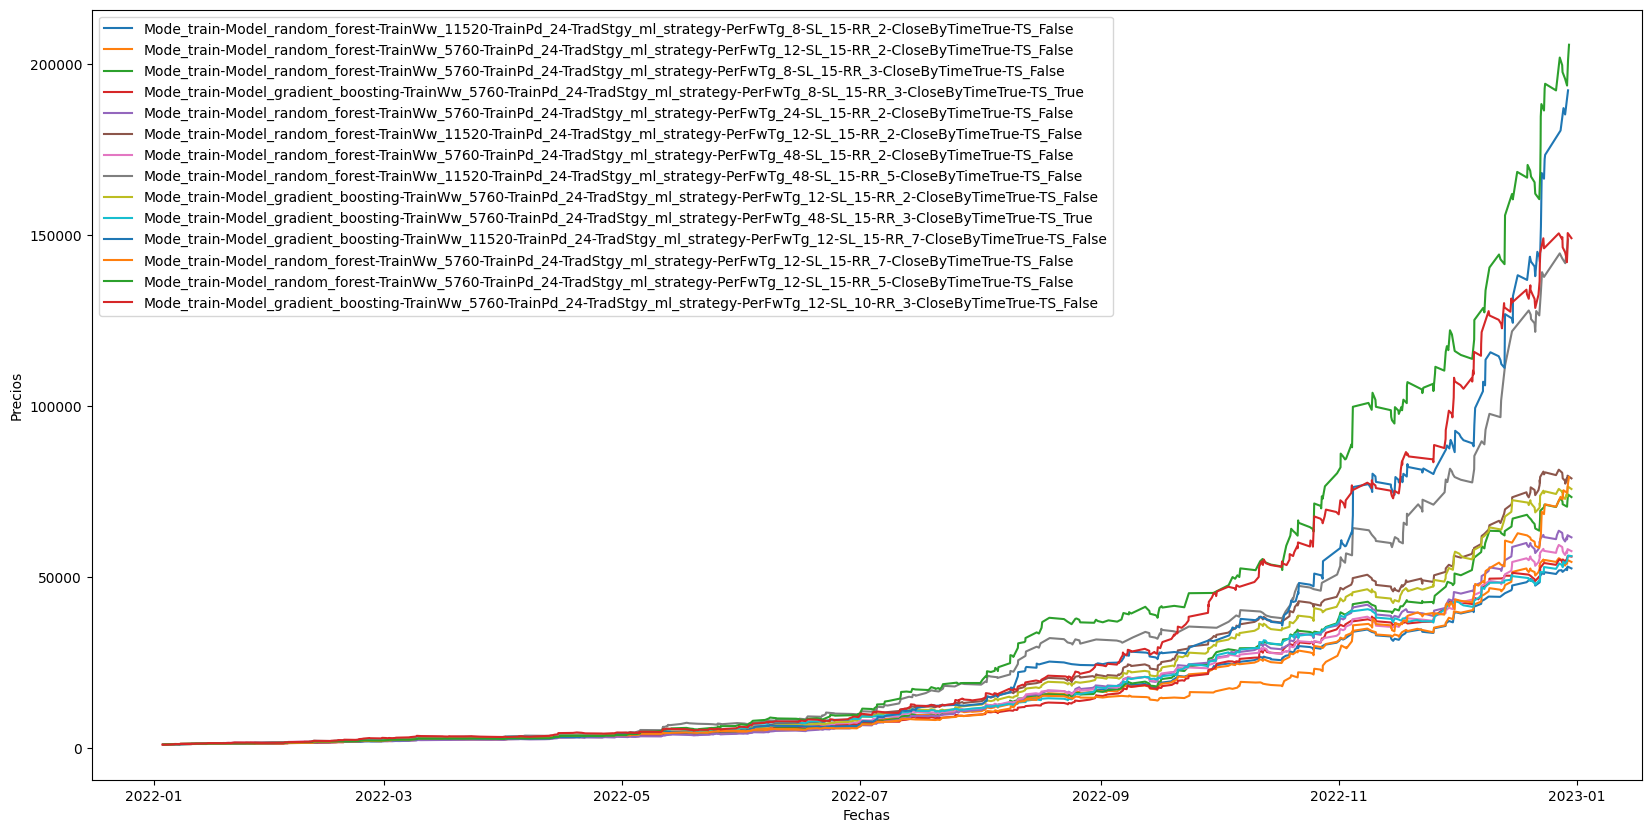

In [15]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

filter_results = positive_results
fig, ax = plt.subplots(figsize=(20, 10))
for path in filter_results.index:

    wallet = pd.read_csv(os.path.join('./backbone/data/backtest/experiments', path, 'wallet.csv'))

    # Datos de ejemplo
    x_wallet = pd.to_datetime(wallet['date'])
    y_wallet = wallet['wallet']  # Datos para la línea
    
    # Crear una figura y ejes
    
    # Agregar la línea
    ax.plot(x_wallet, y_wallet, label=f'{path}')
    
# Etiquetas de los ejes y leyenda
ax.set_xlabel('Fechas')
ax.set_ylabel('Precios')
ax.legend()
    
    # Mostrar el gráfico
    # print(path)
plt.show()
    # time.sleep(5)
    # clear_output(wait=True)

In [16]:
import re

In [17]:
filter_results = results[results['wallet']>0]


In [18]:
filter_results = filter_results.reset_index().rename(columns={'index':'experiment'})

In [19]:
filter_results['model'] = filter_results['experiment'].apply(lambda x: re.search(r'-Model_(.*?)-', x).group(1))
filter_results['window'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainWw_(.*?)-', x).group(1))
filter_results['train_period'] = filter_results['experiment'].apply(lambda x: re.search(r'-TrainPd_(.*?)-', x).group(1))
filter_results['strategy'] = filter_results['experiment'].apply(lambda x: re.search(r'-TradStgy_(.*?)-', x).group(1))
filter_results['periods_forward_target'] = filter_results['experiment'].apply(lambda x: re.search(r'-PerFwTg_(.*?)-', x).group(1))
filter_results['sl'] = filter_results['experiment'].apply(lambda x: re.search(r'-SL_(.*?)-', x).group(1))
filter_results['rr'] = filter_results['experiment'].apply(lambda x: re.search(r'-RR_(.*?)-', x).group(1))
# filter_results['use_days_to_close'] = filter_results['experiment'].apply(lambda x: x.split('UseDaysClose_')[1])

In [20]:
print(filter_results['strategy'].value_counts())
print('-----------------------------------------')
print(filter_results['model'].value_counts())
print('-----------------------------------------')
print(filter_results['window'].value_counts())
print('-----------------------------------------')
print(filter_results['rr'].value_counts())
print('-----------------------------------------')
print(filter_results['sl'].value_counts())
print('-----------------------------------------')
print(filter_results['periods_forward_target'].value_counts())

strategy
ml_strategy    139
Name: count, dtype: int64
-----------------------------------------
model
random_forest        73
gradient_boosting    66
Name: count, dtype: int64
-----------------------------------------
window
5760     73
11520    66
Name: count, dtype: int64
-----------------------------------------
rr
2    38
5    35
3    34
7    32
Name: count, dtype: int64
-----------------------------------------
sl
10    74
15    65
Name: count, dtype: int64
-----------------------------------------
periods_forward_target
12    34
24    29
8     29
48    24
4     23
Name: count, dtype: int64


In [21]:
gb = filter_results.groupby(
    by=['strategy', 'model', 'window', 'rr', 'periods_forward_target']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio', 'mean'), ascending=False).dropna().round(4)

sharpe_ratio  \
                                                                       mean   
strategy    model             window rr periods_forward_target                
ml_strategy random_forest     11520  5  48                          23.9618   
                                     3  4                           23.7459   
                              5760   5  4                           23.4232   
                                     2  4                           23.2923   
                              11520  2  24                          23.1584   
                                     7  12                          23.1495   
            gradient_boosting 11520  5  48                          23.0690   
            random_forest     11520  2  12                          22.8996   
            gradient_boosting 11520  2  12                          22.8437   
            random_forest     11520  7  24                          22.2247   
            gradient_boosting 11520  3  12                          22.1923   
            random_forest     11520  3  12                          22.0216   
                              5760   2  24                          22.0046   
            gradient_boosting 5760   3  4                           21.8650   
                                     2  8                           21.8204   
                                     3  12                          21.5085   
                              11520  7  8                           21.2805   
            random_forest     5760   3  8                           21.2091   
            gradient_boosting 5760   7  24                          21.0423   
            random_forest     5760   3  12                          20.8732   
                              11520  3  48                          20.8572   
            gradient_boosting 5760   2  12                          20.7390   
                                     7  8                           20.6933   
                                        12                          20.5678   
            random_forest     11520  5  24                          20.5370   
            gradient_boosting 11520  2  8                           20.4229   
            random_forest     5760   5  24                          20.1869   
            gradient_boosting 5760   5  12                          20.1867   
            random_forest     5760   7  4                           19.7359   
                                     3  24                          19.7247   
                              11520  7  48                          19.5782   
            gradient_boosting 11520  5  12                          19.3870   
                                     3  4                           19.3500   
                              5760   5  4                           19.1862   
            random_forest     5760   7  12                          19.1546   
            gradient_boosting 11520  3  48                          18.5961   
                              5760   2  24                          18.4982   
                                     7  48                          17.4055   
            random_forest     11520  7  8                           17.2996   
                                     3  24                          16.4256   
                              5760   5  12                          15.7096   
            gradient_boosting 5760   2  48                          15.4166   
            random_forest     5760   5  8                           11.0462   
            gradient_boosting 5760   5  8                            9.6163   
                              11520  5  4                            9.4567   
                                        8                            9.3288   
                                     2  4                            8.5300   

                                                                         
                                      

In [22]:
gb = filter_results.groupby(
    by=['rr']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
           mean       std
rr                       
2     20.526410  6.519072
7     20.188312  4.265310
3     20.024453  5.306128
5     17.256733  8.149424

In [23]:
gb = filter_results.groupby(
    by=['sl']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
           mean       std
sl                       
15    20.954674  6.995112
10    18.226930  5.458627

In [24]:
gb = filter_results.groupby(
    by=['window']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
               mean       std
window                       
5760      19.547890  5.747412
11520     19.452283  7.000633

In [25]:
gb = filter_results.groupby(
    by=['periods_forward_target']
).agg(
    {
        'sharpe_ratio':['mean', 'std']
    }
)


gb.sort_values(by=('sharpe_ratio','mean'), ascending=False)

sharpe_ratio          
                               mean       std
periods_forward_target                       
12                        20.617011  4.183556
24                        20.341614  4.261925
48                        19.212379  6.529407
4                         18.848677  7.726271
8                         18.115337  8.564717

In [26]:
0/0

ZeroDivisionError: division by zero

In [ ]:
results_dict = {}

for path in os.listdir('./data'):
    if not path.endswith('.csv') and path.startswith('test_'):
        print(path)
        results_dict[path] = {}

        try:
            wallet = pd.read_csv(os.path.join('./data', path, 'wallet.csv'))
            results_dict[path]['wallet'] = wallet.tail(1).iloc[0]['wallet']
        except:
            results_dict[path]['wallet'] = 0

        try:
            orders = pd.read_csv(os.path.join('./data', path, 'orders.csv'))
            results_dict[path]['buys'] = orders[orders['open_date'].notna()].shape[0]
            results_dict[path]['sells'] = orders[orders['close_date'].notna()].shape[0]
           
            avg_incomes = orders.groupby('ticker')['profit'].sum().mean()
            results_dict[path]['avg_incomes'] = avg_incomes
            results_dict[path]['good_operations'] = orders[orders['profit'] > 0].shape[0]
            results_dict[path]['bad_operations'] = orders[orders['profit'] <= 0].shape[0]
            results_dict[path]['operation_ratio'] = results_dict[path]['good_operations'] / (results_dict[path]['good_operations'] + results_dict[path]['bad_operations']) 

        except:
            results_dict[path]['buys'] = 0
            results_dict[path]['sells'] = 0
            avg_incomes = 0
            results_dict[path]['avg_incomes'] = 0
            results_dict[path]['good_operations'] = 0
            results_dict[path]['bad_operations'] = 0
            results_dict[path]['operation_ratio'] = 0

        try:
            train_results = pd.read_csv(os.path.join('./data', path, 'train_results.csv'))
            avg_train_auc = train_results['auc'].mean()
            results_dict[path]['avg_train_auc'] = avg_train_auc
        except:
            results_dict[path]['avg_train_auc'] = 0
            
        try:
            stock_predictions = pd.read_csv(os.path.join('./data', path, 'stock_predictions.csv'))
            true_values = pd.read_csv(os.path.join('./data', path, 'stock_true_values.csv'))

            avg_auc_score = calculate_auc_avg(tickers, stock_predictions, true_values)
            results_dict[path]['avg_test_auc'] = avg_auc_score
        except:
            results_dict[path]['avg_test_auc'] = 0

results = pd.DataFrame.from_dict(results_dict, orient='index')


Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_720-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_2-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_5-SL_15-RR_3-UseDaysClose_False







Mode_train-Model_gradient_boosting-TrainWw_1440-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False

Mode_train-Model_random_forest-TrainWw_960-TrainPd_24-TradingStgy_macd_strategy-PeriodsFwTg_8-SL_15-RR_3-UseDaysClose_False